<a href="https://colab.research.google.com/github/MathewBiddle/sandbox/blob/main/notebooks/MBON_OBIS_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["geoplot", "pyobis"]
_colab_install_missing_deps(deps)

Install geoplot? [y/n]:y
geoplot installed!
Install pyobis? [y/n]:y
pyobis installed!


# Using pyobis to query for known datasets

Created: 2022-11-23

Updated: 2023-03-24


Author: [Mathew Biddle](mailto:mathew.biddle@noaa.gov)

This notebook uses the [pyobis](https://github.com/iobis/pyobis) Python package to query the [OBIS API](https://api.obis.org/) for datasets associated with projects funded under the United States Marine Biodiversity Observation Network. The notebook walks through the process for querying the OBIS api for a specific institution, then using the resultant datasets to gather the locations of all the occurrences using the pyobis package.

![image.png](https://marinebon.org/wp-content/uploads/2022/08/MBON_logo_horizontal_60.png)

The [US Marine Biodiversity Observation Network (US MBON)](https://ioos.noaa.gov/project/mbon/) is an interagency initiative that seeks to coordinate across sectors and government to characterize biodiversity and understand drivers of change. US MBON represents a broad, collaborative effort to address the need for systematic collection and sharing of marine life information, ensure that information is available for decision-making and management from local to national levels, and document marine biodiversity status and trends in the face of human- and climate-induced change using a range of technologies and approaches. Through the National Oceanographic Partnership Program, NOAA, NASA, Office of Naval Research, and BOEM have invested in US MBON since 2014, most recently announcing new five year projects in 2022.



In [3]:
import pyobis

pyobis.__version__

'1.4.0'

First off, let's look through the available institutions at OBIS and find the US MBON one.

_Hint: We know the name of the institution is **United States Marine Biodiversity Observation Network**._

In [4]:
import pandas as pd

pd.set_option("max_colwidth", 400)

url = "https://api.obis.org/v3/institute"

institutes = pd.read_json(url)

df_inst = pd.DataFrame.from_records(institutes["results"])

df_inst.dropna(inplace=True)

df_inst["id"] = df_inst["id"].astype(int)

institution = df_inst.loc[
    df_inst["name"].str.contains(
        "United States Marine Biodiversity Observation", na=False
    )
]

institution

,id,name,country,records
58,23070,United States Marine Biodiversity Observation Network,United States of America,1615899


Well that looks like the institution we're after!

Using the `id` we can check it out on the OBIS website: https://obis.org/institute/23070

Yes, that does look like what we want. Now let's use that `id` to query OBIS for all associated datasets.

In [5]:
institution_id = institution["id"].tolist()[0]

institution_id

23070

## Collect metadata about all of the datasets

Here we use the `institution_id` collected from OBIS to query the API for metadata on the datasets associated with that `id`.

First, we build the API call, then we bring it into a Pandas DataFrame and create additional fields for use later.

In [6]:
import pyobis

query = pyobis.dataset.search(instituteid=institution_id)

df = pd.DataFrame(query.execute())

df_meta = pd.DataFrame.from_records(df["results"])

# create a column for the human readable short name of the datasets
df_meta["short_name"] = df_meta["url"].str.split("=", expand=True)[1]

# create another column to group datasets by, which removes the year from the short names
df_meta["short_name_group"] = df_meta["short_name"].replace("\d", "", regex=True)

df_meta.head(5)

,id,url,archive,published,created,updated,core,extensions,statistics,extent,...,intellectualrights,feed,institutes,contacts,nodes,keywords,downloads,records,short_name,short_name_group
0,cfceb150-bbe2-4efb-8682-14cfc7167e7c,https://ipt-obis.gbif.us/resource?r=rcca_transects,https://www1.usgs.gov/obis-usa/ipt/archive.do?r=rcca_transects,2023-01-18T20:38:20.000Z,2020-12-08T01:07:21.790Z,2023-06-03T12:51:53.436Z,event,"[measurementorfact, occurrence]","{'Event': 19375, 'absence': 487162, 'dropped': 0, 'Occurrence': 724871, 'DNADerivedData': 0, 'MeasurementOrFact': 255300}","POLYGON((-124.294724 32.694233000000004,-124.294724 42.045155,-117.264999 42.045155,-117.264999 32.694233000000004,-124.294724 32.694233000000004))",...,"To the extent possible under law, the publisher has waived all rights to these data and has dedicated them to the Public Domain (CC0 1.0)","{'id': '8112d75b-7e78-4641-9e09-9a2cc7db7375', 'url': 'https://ipt-obis.gbif.us/rss.do'}","[{'name': 'U.S. Geological Survey HQ', 'oceanexpert_id': 12976, 'oceanexpert_parent_id': None}, {'name': 'United States Marine Biodiversity Observation Network', 'oceanexpert_id': 23070, 'oceanexpert_parent_id': None}, {'name': 'Central & Northern California Ocean Observing System', 'oceanexpert_id': 23204, 'oceanexpert_parent_id': None}, {'name': 'Reef Check Foundation', 'oceanexpert_id': 232...","[{'role': None, 'type': 'creator', 'givenname': 'Jan', 'surname': 'Friewald', 'organization': 'Reef Check Foundation', 'position': 'Executive Director', 'email': 'jfreiwald@reefcheck.org', 'url': None, 'organization_oceanexpert_id': 23205, 'type_display': 'Creator'}, {'role': None, 'type': 'contact', 'givenname': 'Jan', 'surname': 'Friewald', 'organization': 'Reef Check Foundation', 'position'...","[{'id': 'b7c47783-a020-4173-b390-7b57c4fa1426', 'name': 'OBIS USA'}]","[{'keyword': 'Samplingevent', 'thesaurus': 'GBIF Dataset Type Vocabulary: http://rs.gbif.org/vocabulary/gbif/dataset_type_2015-07-10.xml'}]","[{'year': 2024, 'downloads': 1573, 'records': 155545667}, {'year': 2023, 'downloads': 3648, 'records': 588494102}, {'year': 2022, 'downloads': 4191, 'records': 426899064}, {'year': 2021, 'downloads': 13776, 'records': 497036713}, {'year': 2020, 'downloads': 747, 'records': 26199396}]",237709,rcca_transects,rcca_transects
1,d50e0443-4d84-4bd9-a5ad-4d417a7607e2,https://ipt-obis.gbif.us/resource?r=2009floridakeysrvc,https://ipt-obis.gbif.us/archive.do?r=2009floridakeysrvc,2023-02-21T17:28:10.000Z,None,2023-06-06T16:14:55.499Z,event,"[measurementorfact, occurrence]","{'Event': 2542, 'absence': 353964, 'dropped': 0, 'Occurrence': 451581, 'DNADerivedData': 0, 'MeasurementOrFact': 905704}","POLYGON((-81.9975333 24.4313,-81.9975333 25.7526,-80.08755 25.7526,-80.08755 24.4313,-81.9975333 24.4313))",...,"To the extent possible under law, the publisher has waived all rights to these data and has dedicated them to the Public Domain (CC0 1.0)","{'id': '8112d75b-7e78-4641-9e09-9a2cc7db7375', 'url': 'https://ipt-obis.gbif.us/rss.do'}","[{'name': 'NOAA, Southeast Fisheries Science Center, National Marine Fisheries Service Southeast Miami Laboratory', 'oceanexpert_id': 7534, 'oceanexpert_parent_id': 11379}, {'name': 'Rosenstiel School of Marine & Atmospheric Science, University of Miami', 'oceanexpert_id': 8124, 'oceanexpert_parent_id': None}, {'name': 'U.S. Geological Survey HQ', 'oceanexpert_id': 12976, 'oceanexpert_parent_i...","[{'role': None, 'type': 'creator', 'givenname': 'Jerald', 'surname': 'Ault', 'organization': 'University of Miami, Rosenstiel School of Marine &amp; Atmospheric Science', 'position': 'Program Lead', 'email': 'jault@rsmas.miami.edu', 'url': None, 'organization_oceanexpert_id': 8124, 'type_display': 'Creator'}, {'role': None, 'type': 'creator', 'givenname': 'Jim', 'surname': 'Bohnsack', 'organiz...","[{'id': 'b7c47783-a020-4173-b390-7b57c4fa1426', 'name': 'OBIS USA'}]","[{'keyword': 'Samplingevent', 'thesaurus': 'GBIF Dataset Type Vocabulary: http://rs.gbif.org/vocabulary/gbif

## Collect statistics

Collect number of downloads per year and display on chart.

In [61]:
import numpy as np

df_downloads = pd.DataFrame.from_records(df_meta['downloads'])

#df_downloads.rename(columns={'index':'year'}, inplace=True)

df_downloads.fillna(value=np.nan)

,0,1,2,3,4,5,6
0,"{'year': 2024, 'downloads': 1573, 'records': 155545667}","{'year': 2023, 'downloads': 3648, 'records': 588494102}","{'year': 2022, 'downloads': 4191, 'records': 426899064}","{'year': 2021, 'downloads': 13776, 'records': 497036713}","{'year': 2020, 'downloads': 747, 'records': 26199396}",NaN,NaN
1,"{'year': 2024, 'downloads': 5619, 'records': 65246788}","{'year': 2023, 'downloads': 7679, 'records': 242648438}","{'year': 2022, 'downloads': 7478, 'records': 175113790}","{'year': 2021, 'downloads': 17549, 'records': 204507663}","{'year': 2020, 'downloads': 3443, 'records': 68153160}","{'year': 2019, 'downloads': 293, 'records': 8867930}","{'year': 2018, 'downloads': 1, 'records': 97617}"
2,"{'year': 2024, 'downloads': 5769, 'records': 57629207}","{'year': 2023, 'downloads': 7461, 'records': 215815493}","{'year': 2022, 'downloads': 7273, 'records': 158822384}","{'year': 2021, 'downloads': 17801, 'records': 178906115}","{'year': 2020, 'downloads': 3353, 'records': 59225761}","{'year': 2019, 'downloads': 299, 'records': 7648000}","{'year': 2018, 'downloads': 1, 'records': 87042}"
3,"{'year': 2024, 'downloads': 5598, 'records': 51057171}","{'year': 2023, 'downloads': 7513, 'records': 190581549}","{'year': 2022, 'downloads': 7350, 'records': 139710500}","{'year': 2021, 'downloads': 17831, 'records': 160861289}","{'year': 2020, 'downloads': 3556, 'records': 53543342}","{'year': 2019, 'downloads': 322, 'records': 7049786}","{'year': 2018, 'downloads': 1, 'records': 76543}"
4,"{'year': 2024, 'downloads': 5504, 'records': 50825658}","{'year': 2023, 'downloads': 7385, 'records': 189896655}","{'year': 2022, 'downloads': 7230, 'records': 138680258}","{'year': 2021, 'downloads': 17532, 'records': 160135207}","{'year': 2020, 'downloads': 3446, 'records': 53299681}","{'year': 2019, 'downloads': 341, 'records': 6924827}","{'year': 2018, 'downloads': 1, 'records': 76253}"
5,"{'year': 2024, 'downloads': 5401, 'records': 48460690}","{'year': 2023, 'downloads': 7113, 'records': 180599495}","{'year': 2022, 'downloads': 6965, 'records': 132387456}","{'year': 2021, 'downloads': 16595, 'records': 152199694}","{'year': 2020, 'downloads': 3213, 'records': 50632042}","{'year': 2019, 'downloads': 269, 'records': 6605189}","{'year': 2018, 'downloads': 1, 'records': 72606}"
6,"{'year': 2024, 'downloads': 5626, 'records': 44302844}","{'year': 2023, 'downloads': 7151, 'records': 165968503}","{'year': 2022, 'downloads': 6946, 'records': 122527551}","{'year': 2021, 'downloads': 16787, 'records': 137001971}","{'year': 2020, 'downloads': 3326, 'records': 46782489}","{'year': 2019, 'downloads': 264, 'records': 5813131}","{'year': 2018, 'downloads': 1, 'records': 66979}"
7,"{'year': 2024, 'downloads': 727, 'records': 40857571}","{'year': 2023, 'downloads': 3805, 'records': 159361913}","{'year': 2022, 'downloads': 3804, 'records': 111586878}","{'year': 2021, 'downloads': 1261, 'records': 34625165}",NaN,NaN,NaN
8,"{'year': 2024, 'downloads': 5460, 'records': 42527863}","{'year': 2023, 'downloads': 7316, 'records': 159290696}","{'year': 2022, 'downloads': 7040, 'records': 114702446}","{'year': 2021, 'downloads': 17152, 'records': 131795156}","{'year': 2020, 'downloads': 3474, 'records': 45420293}","{'year': 2019, 'downloads': 316, 'records': 5764191}","{'year': 2018, 'downloads': 1, 'records': 64253}"
9,"{'year': 2024, 'downloads': 5405, 'records': 41063695}","{'year': 2023, 'downloads': 7094, 'records': 153142966}","{'year': 2022, 'downloads': 6928, 'records': 110487360}","{'year': 2021, 'downloads': 17115, 'records': 129196233}","{'year': 2020, 'downloads': 3417, 'records': 43288935}","{'year': 2019, 'downloads': 327, 'records': 5997818}","{'year': 2018, 'downloads': 1, 'records': 61547}"


In [69]:
df_downloads_out = pd.DataFrame({2024:[int(0)],
                                 2023:[int(0)],
                                 2022:[int(0)],
                                 2021:[int(0)],
                                 2020:[int(0)],
                                 2019:[int(0)],
                                 2018:[int(0)]})

for index, row in df_downloads.iterrows():
  row = row.dropna()
  for n in range(0,len(row)):
    # print(n)
    # print(row[n]['downloads'],'\n')
    df_downloads_out[row[n]['year']] = df_downloads_out[row[n]['year']].add(int(row[n]['downloads']))

df_downloads_out

,2024,2023,2022,2021,2020,2019,2018
0,146198,221396,213969,457248,87692,7312,27


<Axes: ylabel='# of downloads'>

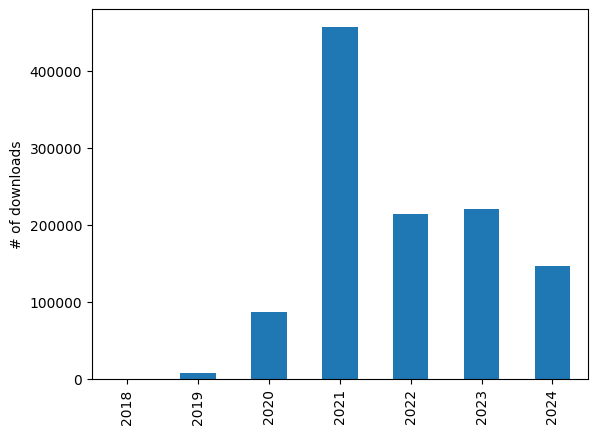

In [77]:
df_downloads_out.T[::-1].plot(kind="bar",legend=False,ylabel='# of downloads')